In [93]:
from prov.model import ProvDocument, Namespace, Literal, PROV, Identifier
import datetime
from prov.dot import prov_to_dot
from IPython.display import Image

In [94]:
# Create a new provenance document
d1 = ProvDocument()

In [95]:
# Declaring namespaces for various prefixes
d1.add_namespace("log", "https://github.com/enriquegalceran/LOGAN-SFH")
d1.add_namespace("ex", "External")
d1.add_namespace("people", "List Of People")
d1.add_namespace("file", "files and documents")


<Namespace: file {files and documents}>

In [96]:
# Entities: Config file
par_config = d1.entity("file:Parameter_config.R",
                       other_attributes={"prov:description": "Parameters that define how the massfunction is going to be generated"})
intermediate_data = d1.bundle("file:Intermediate Data")
intermediate_files_dict = dict()
intermediate_files_dict["intermediate_spectra"] = intermediate_data.entity("file:Input_n.txt")
intermediate_files_dict["intermediate_labels"] = intermediate_data.entity("file:Label_n.txt")
intermediate_files_dict["intermediate_metadata"] = intermediate_data.entity("file:MetaD_n.txt")

# Agent: Enrique
enrique = d1.agent("people:Enrique Galceran")

# Attributing config to Enrique
d1.wasAttributedTo(par_config, enrique)

<ProvAttribution: (file:Parameter_config.R, people:Enrique Galceran)>

In [97]:
ProSpect = d1.activity("ex:ProSpect",
                       other_attributes={"prov:description": "Library that generates Spectra from an SHF+Z"})
d1.agent("people:Aaron Robotham")
data_generation = d1.activity("log:DataGeneration.R")

d1.wasInformedBy(data_generation, ProSpect)
d1.wasAssociatedWith(ProSpect, "people:Aaron Robotham")

d1.used(data_generation, par_config)

# e_dataframe = d1.entity("file:massfunction_dataframe")
for x in intermediate_files_dict.values():
    d1.wasGeneratedBy(x, data_generation)


In [98]:
combine_datasets = d1.activity("log:MUTANTS.ERIK.combine_datasets",
                               other_attributes={"prov:description": "Cleans databases, combines multiple files into "
                                                                     "one, and reduces 64bits to 32bits."})
for x in intermediate_files_dict.values():
    d1.used(combine_datasets, x)

training_data = d1.bundle("file:Training & Validation Data")
training_files_dict = dict()
training_files_dict["training_spectra"] = training_data.entity("file:Input.FITS")
training_files_dict["training_labels"] = training_data.entity("file:Label.FITS")
training_files_dict["training_metadata"] = training_data.entity("file:MetaD.rda")

for x in training_files_dict.values():
    d1.wasGeneratedBy(x, combine_datasets)


In [99]:
jane_config = d1.entity("file:config.txt",
                       other_attributes={"prov:description": "Configuration parameters for the CNN."})
d1.wasAttributedTo(jane_config, enrique)

jane = d1.activity("log:MUTANTS.JANE.train_CNN",
                   other_attributes={"prov:description": "Orquestrator. Generates CNN and trains it"})
d1.used(jane, jane_config)
for x in training_files_dict.values():
    d1.used(jane, x)

model = d1.entity("file:Trained CNN Model",
                  other_attributes={"prov:description": "CNN model trained with the input Training Data."})
d1.wasGeneratedBy(model, jane)

<ProvGeneration: (file:Trained CNN Model, log:MUTANTS.JANE.train_CNN)>

In [100]:
mccoy = d1.activity("log:MUTANTS.McCOY.evaluate_spectra",
                    other_attributes={"prov:description": "Results Verification and Analysis. "
                                                          "Evaluates Validation Data"})

evaluated = d1.entity("file:Evaluated SFH & Z",
                      other_attributes={"prov:description": "SFH+Z evaluated from trained model and validation data. "
                                                            "Additional auxiliary information is also saved."})

d1.used(mccoy, jane_config)
d1.used(mccoy, model)
d1.used(mccoy, training_files_dict["training_spectra"])

d1.wasGeneratedBy(evaluated, mccoy)

<ProvGeneration: (file:Evaluated SFH & Z, log:MUTANTS.McCOY.evaluate_spectra)>

In [101]:
generate_spectra_from_predicted = d1.activity("log:GenerateSpectraFromSFH&Z",
                                              other_attributes={"prov:description": "Generate Spectra from the "
                                                                                    "output of the CNN."})
predicted_spectra = d1.entity("file:Predicted Spectra from model")

d1.wasGeneratedBy(predicted_spectra, generate_spectra_from_predicted)
d1.used(generate_spectra_from_predicted, evaluated)
d1.wasInformedBy(generate_spectra_from_predicted, ProSpect)


<ProvCommunication: (log:GenerateSpectraFromSFH&Z, ex:ProSpect)>

In [102]:
lick = d1.activity("ex:Calculate Lick Indices")
d1.agent("people:Michele Moresco et. al")
d1.wasAssociatedWith(lick, "people:Michele Moresco et. al")

d1.used(lick, predicted_spectra)
d1.used(lick, training_files_dict["training_spectra"])

lick_indices = d1.entity("file:Lick indices input + predicted")


d1.wasGeneratedBy(lick_indices, lick)

<ProvGeneration: (file:Lick indices input + predicted, ex:Calculate Lick Indices)>

In [103]:
mccoy2 = d1.activity("log:MUTANTS.McCOY.colorplot",
                    other_attributes={"prov:description": "Represent Colorplot"})

colorplot = d1.entity("file:Colorplot M_total/burst - Lick",
                      other_attributes={"prov:description": "Colorplot M_total vs M_burst "
                                                            "representing differences in spectra"})

d1.used(mccoy2, lick_indices)
d1.wasGeneratedBy(colorplot, mccoy2)
d1.wasAttributedTo(colorplot, enrique)

<ProvAttribution: (file:Colorplot M_total/burst - Lick, people:Enrique Galceran)>

In [104]:
print(d1.get_provn())

dot  = prov_to_dot(d1)
dot2 = prov_to_dot(d1, show_element_attributes=False, show_relation_attributes=False)
dot.write_png('Provenance_image_complete.png')
dot.write_pdf('Provenance_image_complete.pdf')
dot2.write_png('Provenance_image_no_attr.png')
dot2.write_pdf('Provenance_image_no_attr.pdf')

document
  prefix log <https://github.com/enriquegalceran/LOGAN-SFH>
  prefix ex <External>
  prefix people <List Of People>
  prefix file <files and documents>
  
  entity(file:Parameter_config.R, [prov:description="Parameters that define how the massfunction is going to be generated"])
  agent(people:Enrique Galceran)
  wasAttributedTo(file:Parameter_config.R, people:Enrique Galceran)
  activity(ex:ProSpect, -, -, [prov:description="Library that generates Spectra from an SHF+Z"])
  agent(people:Aaron Robotham)
  activity(log:DataGeneration.R, -, -)
  wasInformedBy(log:DataGeneration.R, ex:ProSpect)
  wasAssociatedWith(ex:ProSpect, people:Aaron Robotham, -)
  used(log:DataGeneration.R, file:Parameter_config.R, -)
  wasGeneratedBy(file:Input_n.txt, log:DataGeneration.R, -)
  wasGeneratedBy(file:Label_n.txt, log:DataGeneration.R, -)
  wasGeneratedBy(file:MetaD_n.txt, log:DataGeneration.R, -)
  activity(log:MUTANTS.ERIK.combine_datasets, -, -, [prov:description="Cleans databases, combine

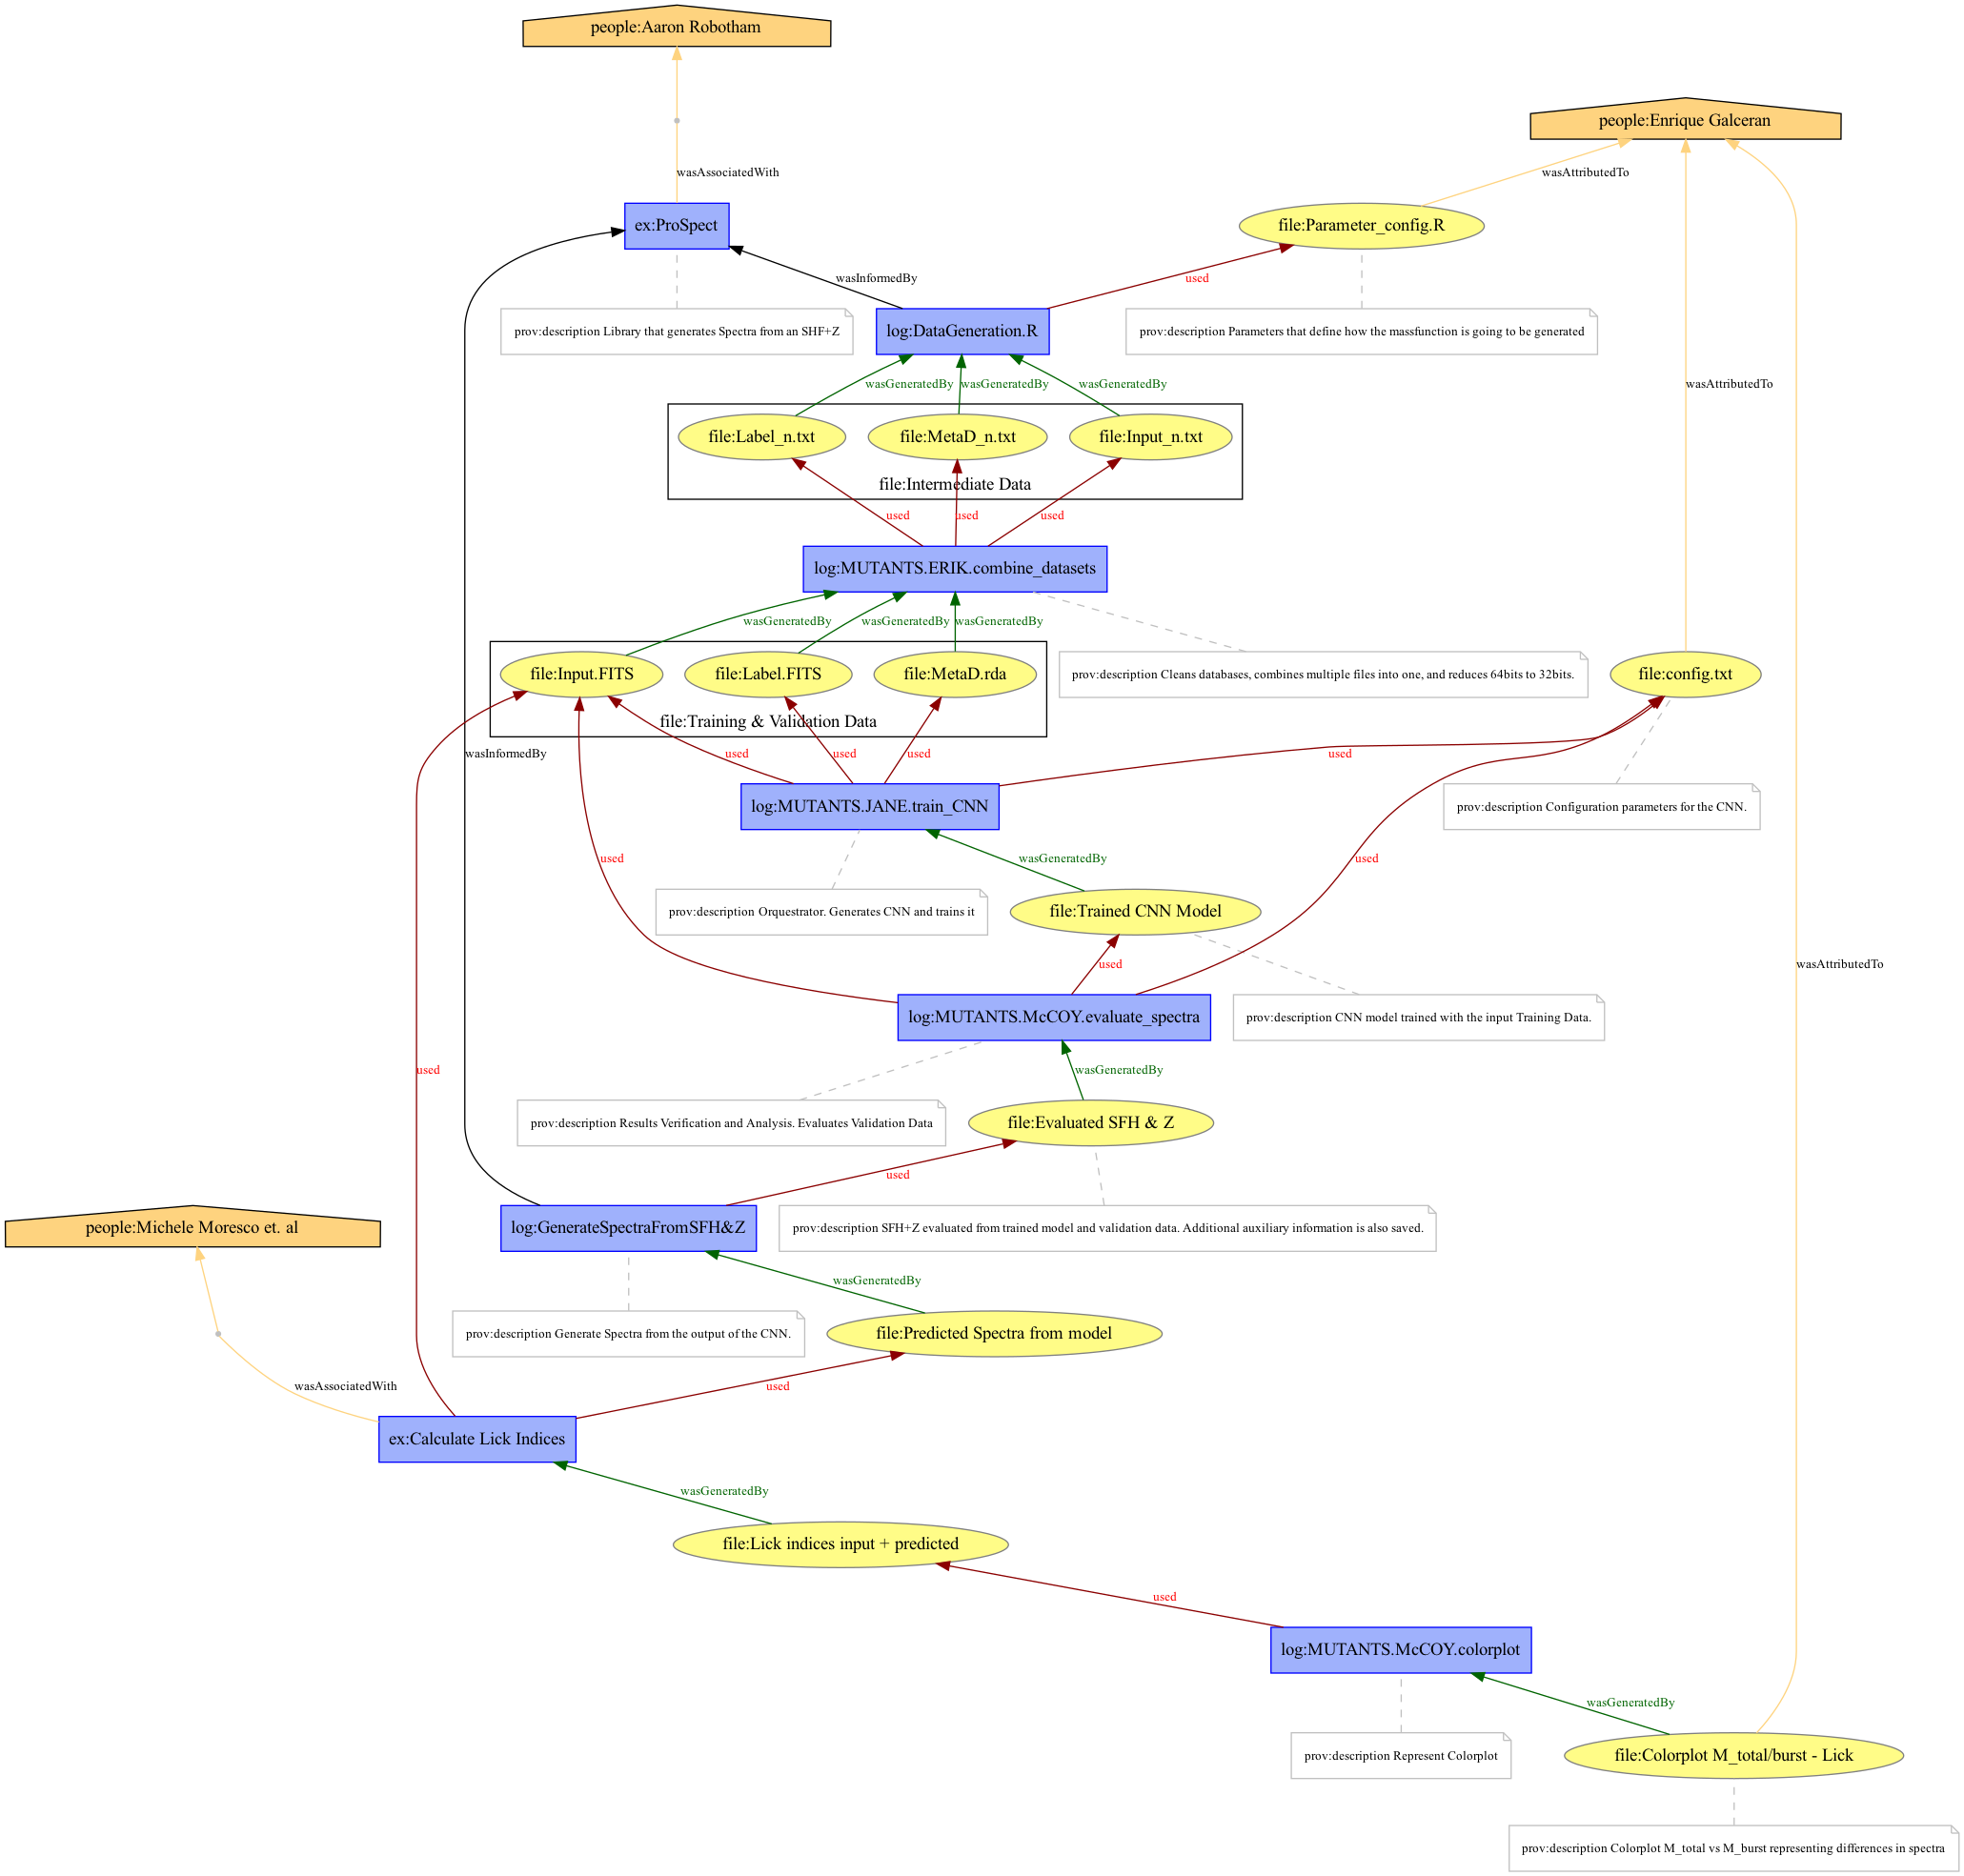

In [105]:
Image('Provenance_image_complete.png')

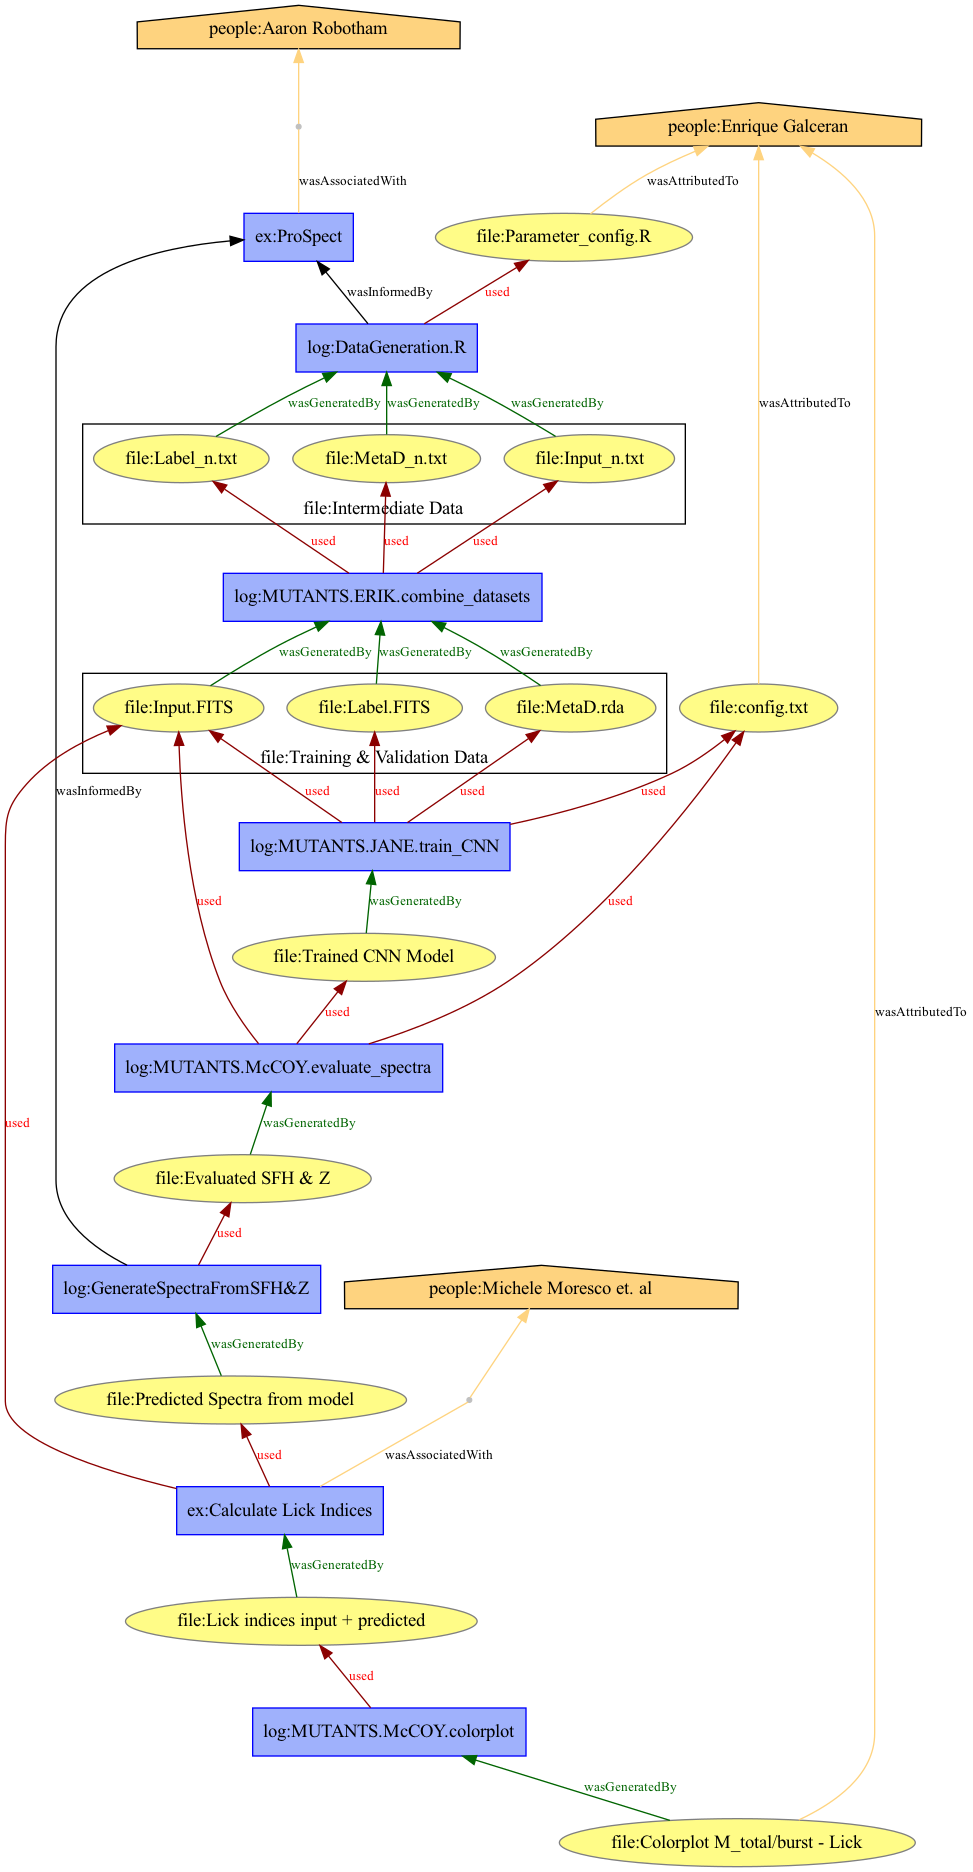

In [106]:
Image('Provenance_image_no_attr.png')
